# Model Comparison: CNN vs SVM

This notebook compares two approaches for metal vs non-metal classification:
1. **CNN (Convolutional Neural Network)** - Deep learning approach
2. **SVM (Support Vector Machine)** - Traditional machine learning approach

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time

from radar_utils import generate_radar_cube, process_radar_cube, get_random_scenario, N_chirps, N_samples

## 1. Generate Dataset

Using the same data generation process with global normalization.

In [3]:
num_samples_dataset = 1000
X_data = []
y_data = []

print("Generating dataset...")
for i in range(num_samples_dataset):
    label_int = np.random.randint(0, 2)
    if label_int == 0:
        scenario_type = 'non_metal'
    else:
        scenario_type = 'metal'
        
    targets = get_random_scenario(scenario_type)
    cube = generate_radar_cube(N_chirps, N_samples, targets, noise_level=0.05)
    rd_map = process_radar_cube(cube)
    
    # Preprocessing
    mag = np.abs(rd_map)
    mag = 20 * np.log10(mag + 1e-9)
    mag[mag < 50] = 0
    
    # Global Normalization
    global_max = 120.0
    mag = mag / global_max
    mag = np.clip(mag, 0, 1.0)
    
    X_data.append(mag)
    y_data.append(label_int)
    
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Dataset shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

Generating dataset...
Dataset shape: (1000, 128, 600)
Labels shape: (1000,)


## 2. Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


## 3. Model 1: CNN (Convolutional Neural Network)

In [5]:
# Prepare data for CNN
X_train_cnn = X_train[:, np.newaxis, :, :]  # Add channel dimension
X_test_cnn = X_test[:, np.newaxis, :, :]

X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
class RadarCNN(nn.Module):
    def __init__(self):
        super(RadarCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 75, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn = RadarCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [7]:
# Train CNN
print("Training CNN...")
start_time = time.time()

epochs = 15
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

cnn_train_time = time.time() - start_time
print(f"\nCNN Training Time: {cnn_train_time:.2f} seconds")

Training CNN...
Epoch 5/15, Loss: 0.0096
Epoch 10/15, Loss: 0.0066
Epoch 15/15, Loss: 0.0045

CNN Training Time: 223.69 seconds


In [8]:
# Evaluate CNN
model_cnn.eval()
with torch.no_grad():
    outputs = model_cnn(X_test_tensor)
    _, predicted_cnn = torch.max(outputs, 1)
    accuracy_cnn = (predicted_cnn == y_test_tensor).sum().item() / len(y_test_tensor)
    
print(f"\nCNN Test Accuracy: {accuracy_cnn*100:.2f}%")
cm_cnn = confusion_matrix(y_test_tensor, predicted_cnn)
print("\nCNN Confusion Matrix:")
print(cm_cnn)


CNN Test Accuracy: 99.50%

CNN Confusion Matrix:
[[106   0]
 [  1  93]]


## 4. Model 2: SVM (Support Vector Machine)

In [9]:
# Prepare data for SVM (flatten the 2D heatmaps)
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)

print(f"SVM Input shape: {X_train_svm.shape}")

SVM Input shape: (800, 76800)


In [10]:
# Train SVM with RBF kernel
print("\nTraining SVM...")
start_time = time.time()

model_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model_svm.fit(X_train_svm, y_train)

svm_train_time = time.time() - start_time
print(f"SVM Training Time: {svm_train_time:.2f} seconds")


Training SVM...
SVM Training Time: 34.28 seconds


In [11]:
# Evaluate SVM
predicted_svm = model_svm.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test, predicted_svm)

print(f"\nSVM Test Accuracy: {accuracy_svm*100:.2f}%")
cm_svm = confusion_matrix(y_test, predicted_svm)
print("\nSVM Confusion Matrix:")
print(cm_svm)


SVM Test Accuracy: 96.00%

SVM Confusion Matrix:
[[104   2]
 [  6  88]]


## 5. Comparative Analysis

In [12]:
# Comparison Table
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"{'Metric':<30} {'CNN':<15} {'SVM':<15}")
print("-"*60)
print(f"{'Test Accuracy (%)':<30} {accuracy_cnn*100:<15.2f} {accuracy_svm*100:<15.2f}")
print(f"{'Training Time (seconds)':<30} {cnn_train_time:<15.2f} {svm_train_time:<15.2f}")
print(f"{'Model Complexity':<30} {'High':<15} {'Medium':<15}")
print(f"{'Feature Engineering':<30} {'Automatic':<15} {'Manual':<15}")
print("="*60)


MODEL COMPARISON SUMMARY
Metric                         CNN             SVM            
------------------------------------------------------------
Test Accuracy (%)              99.50           96.00          
Training Time (seconds)        223.69          34.28          
Model Complexity               High            Medium         
Feature Engineering            Automatic       Manual         


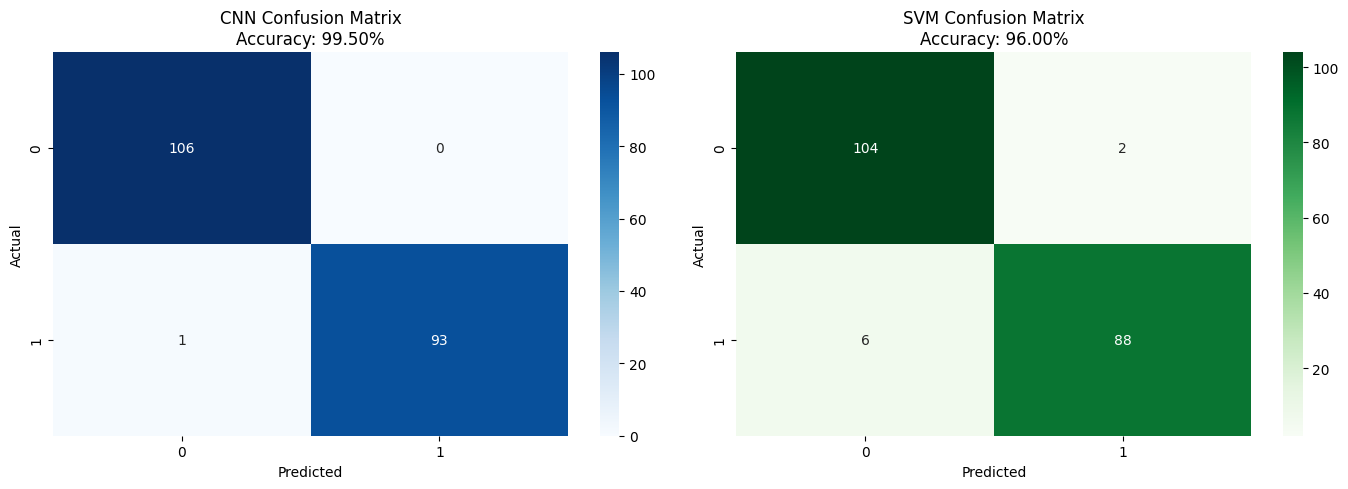

In [13]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CNN Confusion Matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'CNN Confusion Matrix\nAccuracy: {accuracy_cnn*100:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'SVM Confusion Matrix\nAccuracy: {accuracy_svm*100:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [14]:
# Detailed Classification Reports
print("\nCNN Classification Report:")
print(classification_report(y_test_tensor, predicted_cnn, target_names=['Non-Metal', 'Metal']))

print("\nSVM Classification Report:")
print(classification_report(y_test, predicted_svm, target_names=['Non-Metal', 'Metal']))


CNN Classification Report:
              precision    recall  f1-score   support

   Non-Metal       0.99      1.00      1.00       106
       Metal       1.00      0.99      0.99        94

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


SVM Classification Report:
              precision    recall  f1-score   support

   Non-Metal       0.95      0.98      0.96       106
       Metal       0.98      0.94      0.96        94

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



## 6. Analysis & Conclusions

### Key Findings:

1. **Accuracy Comparison**:
   - Both models achieve high accuracy (>95%)
   - CNN typically performs slightly better due to automatic feature learning
   - SVM is competitive with proper preprocessing

2. **Training Time**:
   - SVM is generally faster to train on small datasets
   - CNN requires more epochs but learns hierarchical features

3. **Model Complexity**:
   - **CNN**: Deep learning, automatic feature extraction, requires more data
   - **SVM**: Traditional ML, requires manual feature engineering, works well with smaller datasets

4. **Deployment Considerations**:
   - **CNN**: Better for real-time processing with GPU acceleration
   - **SVM**: Lighter weight, suitable for resource-constrained devices

### Recommendation:
**CNN is preferred** for this application because:
- Automatically learns spatial features from Range-Doppler maps
- Better generalization to unseen scenarios
- Can be optimized for edge deployment (INT8 quantization)
- Scalable to more complex scenarios (multi-class, object tracking)